### SetUp

In [1]:
!pip install torch torchvision timm opencv-python pillow imageio gdown tqdm matplotlib seaborn numpy

In [15]:
# @title Step 1: Loading Model
# @markdown Loading Model

import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageSequence, ImageFilter
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import timm
import cv2
from tqdm import tqdm
import imageio
import gdown
import zipfile
from pathlib import Path

import warnings
warnings.filterwarnings('ignore')

# ============================================================================
# CONFIGURATION
# ============================================================================

MODEL_TYPE = 'msvit'
MODEL_NAME = 'maxvit_tiny_tf_224.in1k'
IMG_SIZE = 224
OUTPUT_DIR = 'inference_results'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ============================================================================
# GRAD-CAM IMPLEMENTATION
# ============================================================================

class GradCAM:
    """Grad-CAM using module-level forward + full-backward hooks"""
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.activations = None
        self.gradients = None

        def _forward_hook(module, input, output):
            if isinstance(output, torch.Tensor):
                self.activations = output
            elif isinstance(output, (tuple, list)):
                for elem in output:
                    if isinstance(elem, torch.Tensor):
                        self.activations = elem
                        break

        def _backward_hook(module, grad_input, grad_output):
            if isinstance(grad_output, (tuple, list)):
                g = grad_output[0]
            else:
                g = grad_output
            if isinstance(g, torch.Tensor):
                self.gradients = g.detach()

        self._fwd_handle = self.target_layer.register_forward_hook(_forward_hook)
        if hasattr(self.target_layer, "register_full_backward_hook"):
            self._bwd_handle = self.target_layer.register_full_backward_hook(
                lambda module, grad_input, grad_output: _backward_hook(module, grad_input, grad_output)
            )
        else:
            self._bwd_handle = self.target_layer.register_backward_hook(
                lambda module, grad_input, grad_output: _backward_hook(module, grad_input, grad_output)
            )

    def generate_cam(self, input_image, target_class=None):
        """Run forward+backward to get CAM"""
        was_training = self.model.training
        self.model.eval()

        with torch.enable_grad():
            output = self.model(input_image)
            if target_class is None:
                target_class = output.argmax(dim=1).item()

            self.model.zero_grad()
            score = output[0, target_class]
            score.backward(retain_graph=False)

            if self.activations is None or self.gradients is None:
                raise RuntimeError("GradCAM failed: activations or gradients are None")

            activations = self.activations[0]
            gradients = self.gradients[0]

            if activations.dim() == 4 and activations.shape[0] == 1:
                activations = activations.squeeze(0)
                gradients = gradients.squeeze(0)

            weights = gradients.mean(dim=(1, 2), keepdim=True)
            cam = (weights * activations).sum(dim=0)
            cam = F.relu(cam)
            cam = cam - cam.min()
            cam = cam / (cam.max() + 1e-8)

        if was_training:
            self.model.train()

        return cam.detach().cpu().numpy(), target_class

    def remove_hooks(self):
        try:
            if hasattr(self, "_fwd_handle") and self._fwd_handle is not None:
                self._fwd_handle.remove()
        except Exception:
            pass
        try:
            if hasattr(self, "_bwd_handle") and self._bwd_handle is not None:
                self._bwd_handle.remove()
        except Exception:
            pass

# ============================================================================
# SETUP FUNCTION: DOWNLOAD AND LOAD MODEL
# ============================================================================

def setup_model():
    """Download model from Google Drive and load it"""
    print("\n" + "="*70)
    print("🏥 CHEST X-RAY INFERENCE SETUP")
    print("="*70)
    print(f"🔧 Using device: {device}")
    print(f"📊 Model Type: {MODEL_TYPE.upper()}")

    # Download and extract model
    print("\n📥 Downloading model from Google Drive...")
    file_id = "1AR1ONlaj4aTkprlYJOt6JREPLjXTpTJF"
    zip_path = "model.zip"
    extract_dir = "saved_model"

    url = f"https://drive.google.com/uc?id={file_id}"
    gdown.download(url, zip_path, quiet=False)

    print(f"✓ Download complete!")
    print(f"\n📦 Extracting model...")

    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)

    print(f"✓ Extraction complete!")

    # Find the model file
    model_path = None
    for root, dirs, files in os.walk(extract_dir):
        for file in files:
            if file.endswith('.pth'):
                model_path = os.path.join(root, file)
                break
        if model_path:
            break

    if not model_path:
        raise FileNotFoundError("No .pth model file found in extracted archive")

    print(f"✓ Model found at: {model_path}")
    os.remove(zip_path)

    # Load model
    print(f"\n📂 Loading model...")
    checkpoint = torch.load(model_path, map_location=device, weights_only=False)

    model = timm.create_model(MODEL_NAME, pretrained=False, num_classes=0)

    for param in model.parameters():
        param.requires_grad = False

    in_features = model.num_features

    model.head = nn.Sequential(
        nn.AdaptiveAvgPool2d(1),
        nn.Flatten(),
        nn.LayerNorm(in_features),
        nn.Linear(in_features, 768),
        nn.GELU(),
        nn.Dropout(p=0.3),
        nn.LayerNorm(768),
        nn.Linear(768, 384),
        nn.GELU(),
        nn.Dropout(p=0.2),
        nn.LayerNorm(384),
        nn.Linear(384, 2)
    )

    model.load_state_dict(checkpoint['model_state_dict'])
    model = model.to(device)
    model.eval()

    class_names = checkpoint.get('class_names', ['NORMAL', 'PNEUMONIA'])

    print(f"✅ Model loaded successfully!")
    print(f"   • Classes: {class_names}")
    if 'balanced_acc' in checkpoint:
        print(f"   • Balanced Val Acc: {checkpoint['balanced_acc']*100:.2f}%")
    elif 'val_acc' in checkpoint:
        print(f"   • Validation Acc: {checkpoint['val_acc']*100:.2f}%")

    print("\n" + "="*70)
    print("✅ SETUP COMPLETE!")
    print("="*70)

    return model, class_names

# ============================================================================
# UPLOAD AND INFERENCE FUNCTION
# ============================================================================

def upload_and_inference(model, class_names, verbose=True):
    """Upload image and run inference"""
    if verbose:
        print("\n" + "="*70)
        print("📤 UPLOAD IMAGE FOR INFERENCE")
        print("="*70)

    # Upload image (Colab-friendly)
    try:
        from google.colab import files
        if verbose:
            print("\n📁 Please upload a chest X-ray image:")
        uploaded = files.upload()

        if not uploaded:
            if verbose:
                print("❌ No file uploaded.")
            return None

        filename = list(uploaded.keys())[0]
        upload_dir = "uploaded_images"
        os.makedirs(upload_dir, exist_ok=True)
        image_path = os.path.join(upload_dir, filename)

        with open(image_path, 'wb') as f:
            f.write(uploaded[filename])

        if verbose:
            print(f"✓ Image uploaded: {filename}")

    except ImportError:
        if verbose:
            print("\n📁 Please enter the path to an image file:")
        image_path = input("Image path: ").strip().strip('"').strip("'")

        if not os.path.exists(image_path):
            if verbose:
                print("❌ File not found!")
            return None

    # Create output directory
    img_name = Path(image_path).stem
    output_dir = os.path.join(OUTPUT_DIR, f"inference_{img_name}")
    os.makedirs(output_dir, exist_ok=True)

    # Load and preprocess image
    if verbose:
        print(f"\n🔍 Running inference on: {os.path.basename(image_path)}")

    img_pil = Image.open(image_path).convert('RGB')
    img_array = np.array(img_pil)

    transform = transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                           std=[0.229, 0.224, 0.225])
    ])

    img_tensor = transform(img_pil).unsqueeze(0).to(device)

    # Get prediction
    with torch.no_grad():
        output = model(img_tensor)
        probs = F.softmax(output, dim=1)
        confidence, predicted_class = probs.max(dim=1)

    predicted_class = predicted_class.item()
    confidence = confidence.item()

    if verbose:
        print(f"\n📊 Prediction Results:")
        print(f"   • Class: {class_names[predicted_class]}")
        print(f"   • Confidence: {confidence:.2%}")
        print(f"\n   Probabilities:")
        for i, cls in enumerate(class_names):
            print(f"      - {cls}: {probs[0, i].item():.2%}")

    # Get target layer
    target_layer = None
    if hasattr(model, 'stages') and len(model.stages) > 0:
        target_layer = model.stages[-1]
    else:
        layers = list(model.children())
        target_layer = layers[-2] if len(layers) > 1 else layers[-1]

    for p in target_layer.parameters():
        p.requires_grad = True

    # Generate attention map
    if verbose:
        print(f"\n🎯 Generating attention map using GradCAM...")

    model.eval()
    gradcam = GradCAM(model, target_layer)
    heatmap, _ = gradcam.generate_cam(img_tensor, target_class=predicted_class)
    gradcam.remove_hooks()

    img_display = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
    heatmap_display = cv2.resize(heatmap, (IMG_SIZE, IMG_SIZE))

    # Save original image
    orig_path = os.path.join(output_dir, 'original_image.png')
    Image.fromarray(img_display).save(orig_path)
    if verbose:
        print(f"✓ Original image saved")

    # Create overlay
    heatmap_resized = cv2.resize(heatmap_display, (img_display.shape[1], img_display.shape[0]))
    heatmap_uint8 = np.uint8(255 * heatmap_resized)
    heatmap_colored = cv2.applyColorMap(heatmap_uint8, cv2.COLORMAP_JET)
    heatmap_colored = cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB)

    if img_display.dtype != np.uint8:
        img_display_uint8 = np.uint8(255 * (img_display - img_display.min()) / (img_display.max() - img_display.min()))
    else:
        img_display_uint8 = img_display

    overlay = cv2.addWeighted(img_display_uint8, 0.6, heatmap_colored, 0.4, 0)

    # Save static visualization
    static_path = os.path.join(output_dir, f'attention_static_{MODEL_TYPE}.png')

    fig, axes = plt.subplots(2, 2, figsize=(14, 12))

    axes[0, 0].imshow(img_display)
    axes[0, 0].set_title('Original X-ray', fontsize=14, fontweight='bold')
    axes[0, 0].axis('off')

    axes[0, 1].imshow(overlay)
    axes[0, 1].set_title('Attention Overlay', fontsize=14, fontweight='bold')
    axes[0, 1].axis('off')

    axes[1, 0].imshow(heatmap_colored)
    axes[1, 0].set_title('Attention Heatmap', fontsize=14, fontweight='bold')
    axes[1, 0].axis('off')

    axes[1, 1].axis('off')
    info_text = f"""
    🏥 DIAGNOSIS RESULTS
    {'='*30}

    Model: {MODEL_TYPE.upper()}

    Prediction: {class_names[predicted_class]}
    Confidence: {confidence:.2%}

    Class Probabilities:
    """

    for i, cls in enumerate(class_names):
        prob = probs[0, i].item()
        bar = '█' * int(prob * 20)
        info_text += f"\n  {cls}: {prob:.2%} {bar}"

    info_text += f"\n\n{'='*30}\n"
    info_text += "🔍 Focus Areas:\n"
    info_text += "  • Red areas indicate strong\n"
    info_text += "    model focus\n"
    info_text += "  • Yellow shows attention regions"

    axes[1, 1].text(0.1, 0.5, info_text, fontsize=11,
                    verticalalignment='center', family='monospace',
                    bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

    plt.suptitle('🔬 Chest X-ray Analysis with Attention Visualization',
                 fontsize=16, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.savefig(static_path, dpi=300, bbox_inches='tight')
    plt.close()

    if verbose:
        print(f"✓ Static visualization saved")

    # Create animated GIF
    if verbose:
        print(f"\n🎬 Creating animated GIF...")

    frames = []
    heatmap_norm = (heatmap_display - heatmap_display.min()) / (heatmap_display.max() - heatmap_display.min() + 1e-8)

    for alpha in np.linspace(0.0, 1.0, 30):
        fig, ax = plt.subplots(figsize=(6, 6), dpi=100)
        ax.imshow(img_display)
        ax.imshow(heatmap_norm, cmap="jet", alpha=alpha)
        ax.axis("off")
        fig.tight_layout(pad=0)
        fig.canvas.draw()

        buf = fig.canvas.buffer_rgba()
        if buf is not None:
            frame = np.asarray(buf, dtype=np.uint8)
            h, w = fig.canvas.get_width_height()
            frame = frame.reshape((h, w, 4))[:, :, :3]
            frames.append(frame)

        plt.close(fig)

    gif_path = os.path.join(output_dir, f'attention_animation_{MODEL_TYPE}.gif')
    imageio.mimsave(gif_path, frames, fps=10, loop=0)
    if verbose:
        print(f"✓ GIF animation saved")

    # Create merged GIF
    if verbose:
        print(f"\n🎨 Creating merged attention GIF...")

    original = Image.open(orig_path).convert('RGBA')
    gif = Image.open(gif_path)

    merged_frames = []
    for frame in ImageSequence.Iterator(gif):
        frame_rgba = frame.convert('RGBA').resize(original.size)
        blurred = frame_rgba.filter(ImageFilter.GaussianBlur(radius=18))

        alpha = 0.35
        r, g, b, a = blurred.split()
        a = a.point(lambda px: int(px * alpha))
        dimmed_frame = Image.merge('RGBA', (r, g, b, a))

        merged = Image.alpha_composite(original, dimmed_frame)
        merged_frames.append(merged)

    merged_path = os.path.join(output_dir, 'merged_attention.gif')
    merged_frames[0].save(
        merged_path,
        save_all=True,
        append_images=merged_frames[1:],
        duration=gif.info.get('duration', 100),
        loop=gif.info.get('loop', 0),
        disposal=2
    )
    if verbose:
        print(f"✓ Merged GIF saved")

    if verbose:
        print("\n" + "="*70)
        print("✅ INFERENCE COMPLETE!")
        print("="*70)
        print(f"\n📂 Results saved to: {output_dir}")

    return output_dir, class_names[predicted_class], confidence

# ============================================================================
# DISPLAY FUNCTIONS
# ============================================================================

def display_static_attention(output_dir, verbose=True):
    """Display the static attention visualization"""
    static_path = os.path.join(output_dir, f'attention_static_{MODEL_TYPE}.png')

    if not os.path.exists(static_path):
        if verbose:
            print("❌ Static visualization not found!")
        return

    if verbose:
        print("\n" + "="*70)
        print("📊 DISPLAYING STATIC ATTENTION VISUALIZATION")
        print("="*70)

    img = Image.open(static_path)
    plt.figure(figsize=(16, 14))
    plt.imshow(img)
    plt.axis('off')
    plt.title('Static Attention Visualization', fontsize=16, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.show()

    if verbose:
        print(f"\n✓ Displayed: {static_path}")

def display_gifs(output_dir, verbose=True):
    """Play the merged attention GIF animation"""
    merged_path = os.path.join(output_dir, 'merged_attention.gif')

    if not os.path.exists(merged_path):
        if verbose:
            print("❌ Merged attention GIF not found!")
        return

    if verbose:
        print("\n" + "="*70)
        print("🎬 PLAYING MERGED ATTENTION GIF")
        print("="*70)

    # Display animated GIF using IPython (works in Colab/Jupyter)
    try:
        from IPython.display import Image as IPImage, display
        display(IPImage(filename=merged_path))
        if verbose:
            print(f"\n✓ Merged attention GIF animation displayed!")
            print(f"   File: {merged_path}")
    except ImportError:
        if verbose:
            print("⚠️  IPython not available. Showing static frames instead...")

        # Fallback: show multiple frames
        merged_gif = Image.open(merged_path)
        gif_frames = [frame.convert('RGB') for frame in ImageSequence.Iterator(merged_gif)]

        num_frames_to_show = min(6, len(gif_frames))
        frame_indices = np.linspace(0, len(gif_frames)-1, num_frames_to_show, dtype=int)

        fig, axes = plt.subplots(2, 3, figsize=(15, 10))
        axes = axes.flatten()

        for i, frame_idx in enumerate(frame_indices):
            axes[i].imshow(gif_frames[frame_idx])
            axes[i].set_title(f'Frame {frame_idx+1}/{len(gif_frames)}', fontsize=10, fontweight='bold')
            axes[i].axis('off')

        plt.suptitle('Merged Attention Animation Frames', fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()

        if verbose:
            print(f"\n✓ Displayed {num_frames_to_show} frames from merged GIF")

# ============================================================================
# MAIN WORKFLOW
# ============================================================================

if __name__ == "__main__":
    # Step 1: Setup - Download and load model
    model, class_names = setup_model()


🏥 CHEST X-RAY INFERENCE SETUP
🔧 Using device: cpu
📊 Model Type: MSVIT

📥 Downloading model from Google Drive...


Downloading...
From (original): https://drive.google.com/uc?id=1AR1ONlaj4aTkprlYJOt6JREPLjXTpTJF
From (redirected): https://drive.google.com/uc?id=1AR1ONlaj4aTkprlYJOt6JREPLjXTpTJF&confirm=t&uuid=83f0d490-356a-4397-b210-8f8d99920476
To: /content/model.zip
100%|██████████| 121M/121M [00:03<00:00, 34.5MB/s]


✓ Download complete!

📦 Extracting model...
✓ Extraction complete!
✓ Model found at: saved_model/saved_model_msvit/best_msvit_model.pth

📂 Loading model...
✅ Model loaded successfully!
   • Classes: ['NORMAL', 'PNEUMONIA']
   • Balanced Val Acc: 81.25%

✅ SETUP COMPLETE!


### Inference

In [20]:
# @title Step 2: Upload and Inference
# @markdown Upload & Inference

output_dir, predicted_class, confidence = upload_and_inference(model, class_names, False)


Saving IM-0007-0001_NORMAL_0.99.png to IM-0007-0001_NORMAL_0.99 (3).png


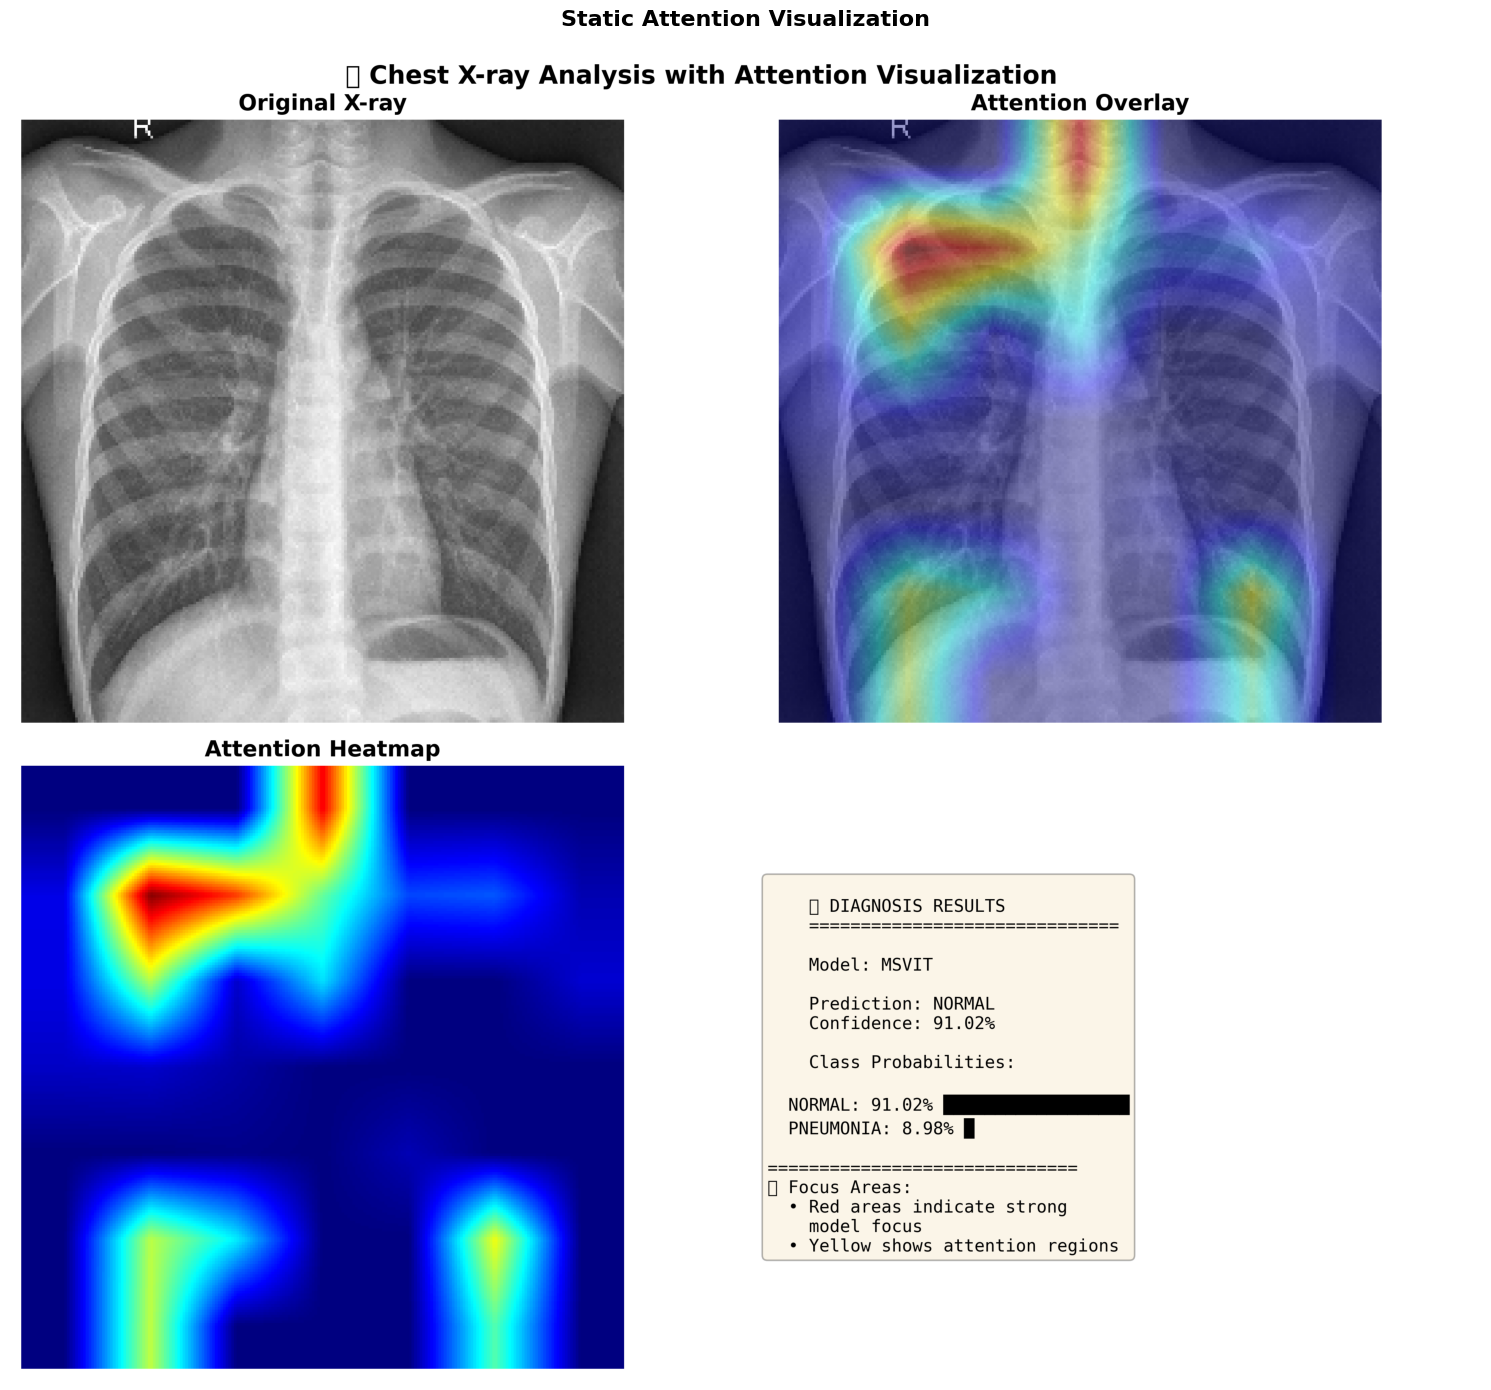

In [13]:
# @title Step 3: Visual Report
# @markdown Visual Report

if output_dir:
    # print(f"\n🎯 Prediction: {predicted_class} ({confidence:.2%} confidence) \n")
    display_static_attention(output_dir,False)

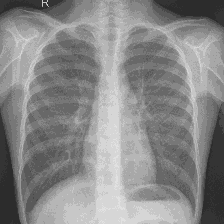

In [14]:
# @title Step 4: Attention Animation
# @markdown Attention Animation

if output_dir:
    # print(f"\n🎯 Prediction: {predicted_class} ({confidence:.2%} confidence)\n")
    display_gifs(output_dir,False)